In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optimizer
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 1, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
# CNN Model - LeNet
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout(0.25)
    self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [ ]:
def optimize(optimizer, loss):
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

def fgsm_attack(model, image, label, criterion, eps):
  init_perturb = torch.zeros_like(image, requires_grad=True)
  output = model(image + init_perturb)
  loss = criterion(output, label)
  loss.backward()
  perturb = eps * init_perturb.grad.detach().sign()
  perturb_image = image + perturb
  return perturb_image

def pgd_attack(model, image, label, criterion, eps, max_iter=20, ls=0.01):
  perturbation = torch.zeros_like(image, requires_grad=True)

  for _ in range(max_iter):
    output = model(image + perturbation)
    loss = criterion(output, label)
    loss.backward()
    step = ls * perturbation.grad.detach().sign()
    perturbation.data = (perturbation + step).clamp(-eps,eps)
    perturbation.grad.zero_()

  perturb_image = image + perturbation.detach()

  return perturb_image

In [ ]:
def train_or_eval(loader, model, criterion, optimizer):
    correct = 0.
    for batch_img, batch_label in loader:
        batch_img, batch_label = batch_img.to(device), batch_label.to(device)
        output = model(batch_img)
        correct += (output.max(dim=1)[1] == batch_label).sum().item()

        loss = criterion(output, batch_label)

        if optimizer is not None:
          optimize(optimizer, loss)

    return correct / len(loader.dataset)


def train_or_eval_adv(loader, model, criterion, adv_generator, optimizer, epsilon=0.3):
    correct = 0.
    for batch_img, batch_label in loader:
        batch_img, batch_label = batch_img.to(device), batch_label.to(device)
        perturb_img = adv_generator(model, batch_img, batch_label, criterion, epsilon)
        output = model(perturb_img)
        correct += (output.max(dim=1)[1] == batch_label).sum().item()

        loss = criterion(output, batch_label)

        optimize(optimizer, loss)

    return correct / len(loader.dataset)

In [ ]:
def gen_adv(loader, model, adv_generator, criterion, epsilon):
  examples = []
  correct = 0.
  for batch_img, batch_label in loader:
    batch_img, batch_label = batch_img.to(device), batch_label.to(device)
    perturb_img = adv_generator(model, batch_img, batch_label, criterion, eps=epsilon)
    output = model(perturb_img)
    correct += (output.max(dim=1)[1] == batch_label).sum().item()
    perturb_img = perturb_img.squeeze().detach().cpu().numpy()
    examples.append([perturb_img, batch_label])

  return correct / len(loader.dataset), examples

def display_images(adv_examples, num_images=5):
  plt.figure(figsize=(10, 10))
  for i in range(num_images):
    idx = np.random.randint(0, len(adv_examples))
    ex, target = adv_examples[idx]
    plt.subplot(1, num_images, i+1)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title(f"{target.item()}")
    plt.imshow(ex, cmap="gray")
  plt.show()

def adversarial_report(loader, model, adv_generator, criterion):
  epsilons = [0.1, 0.2, 0.5]

  for eps in epsilons:
    acc, adv_examples = gen_adv(loader, model, adv_generator, criterion, eps)
    print(f"Accuracy for epsilon {eps}: {acc*100:.2f}%")
    display_images(adv_examples)

In [ ]:
model = CNN().to(device)
opt_std = optimizer.SGD(model.parameters(), lr=1e-1)
train_acc = train_or_eval(train_loader, model, criterion, opt_std)

In [ ]:
#standard model on standard test
train_or_eval(test_loader, model, criterion, None)

0.9555

Accuracy for epsilon 0.1: 78.53%


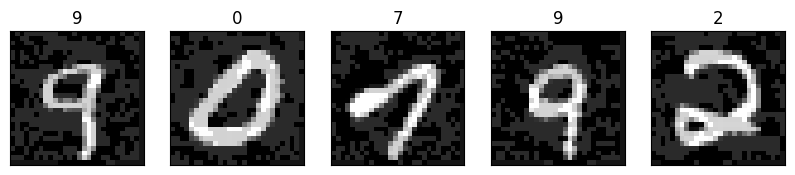

Accuracy for epsilon 0.2: 43.39%


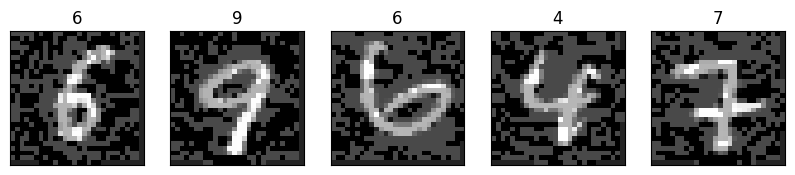

Accuracy for epsilon 0.5: 1.92%


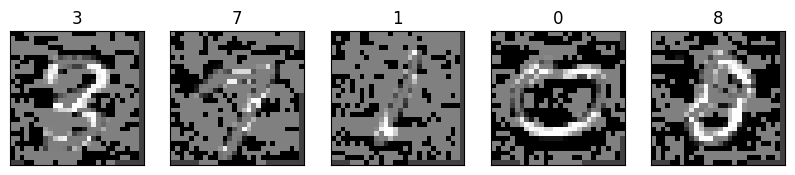

In [ ]:
#standard model on fgsm test
adversarial_report(test_loader, model, fgsm_attack, criterion)

Accuracy for epsilon 0.1: 69.96%


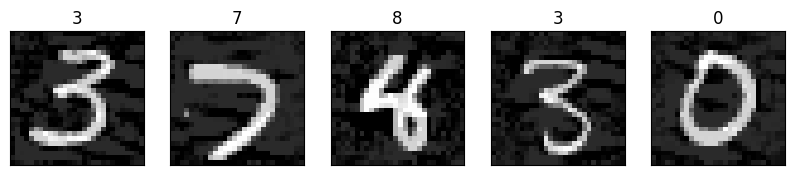

Accuracy for epsilon 0.2: 24.42%


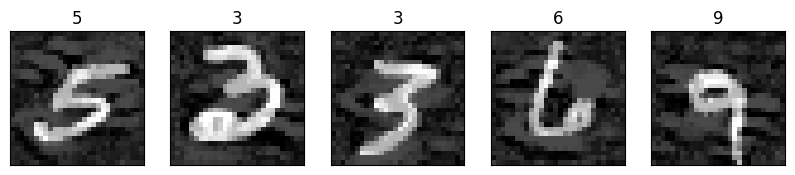

Accuracy for epsilon 0.5: 24.75%


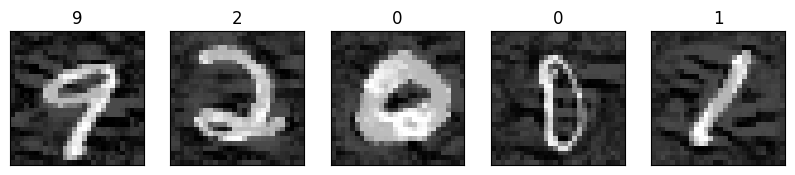

In [ ]:
#standard model on pgd test
adversarial_report(test_loader, model, pgd_attack, criterion)

In [ ]:
model_fgsm = CNN().to(device)
opt_fgsm = optimizer.SGD(model_fgsm.parameters(), lr=1e-1)
train_acc = train_or_eval_adv(train_loader, model_fgsm, criterion, fgsm_attack, opt_fgsm)

In [ ]:
#fgsm model on standard test
train_or_eval(test_loader, model_fgsm, criterion, None)

0.9071

Accuracy for epsilon 0.1: 85.46%


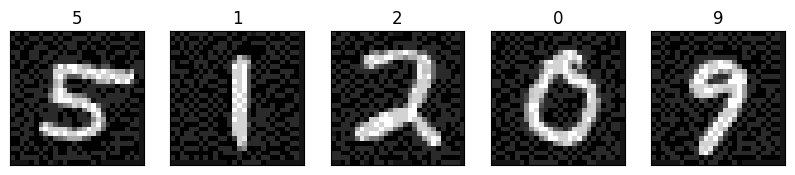

Accuracy for epsilon 0.2: 81.40%


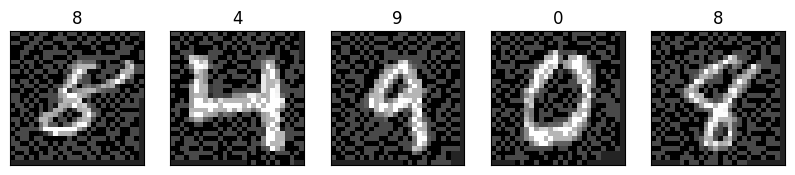

Accuracy for epsilon 0.5: 65.80%


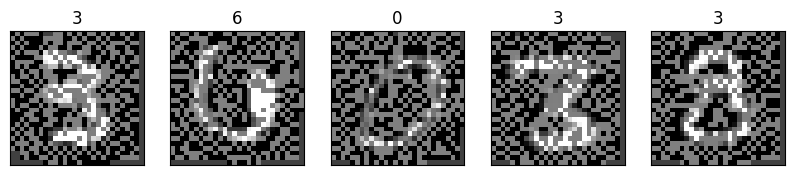

In [ ]:
#fgsm model on fgsm test
adversarial_report(test_loader, model_fgsm, fgsm_attack, criterion)

Accuracy for epsilon 0.1: 77.66%


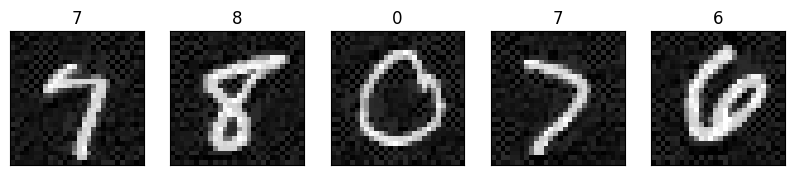

Accuracy for epsilon 0.2: 58.06%


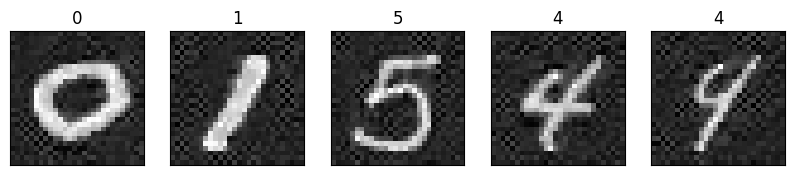

Accuracy for epsilon 0.5: 57.62%


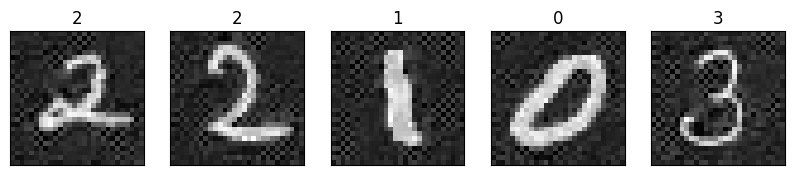

In [ ]:
#fgsm model on pgd test
adversarial_report(test_loader, model_fgsm, pgd_attack, criterion)

In [ ]:
model_pgd = CNN().to(device)
opt_pgd = optimizer.SGD(model_pgd.parameters(), lr=1e-1)
train_acc = train_or_eval_adv(train_loader, model_pgd, criterion, pgd_attack, opt_pgd)

In [ ]:
#pgd model on standard test
train_or_eval(test_loader, model_pgd, criterion, None)

0.9496

Accuracy for epsilon 0.1: 91.84%


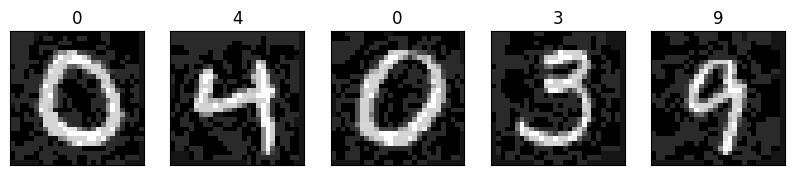

Accuracy for epsilon 0.2: 85.49%


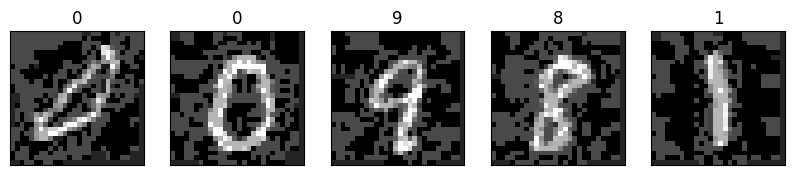

Accuracy for epsilon 0.5: 43.51%


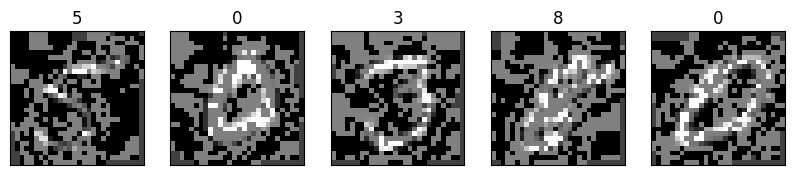

In [ ]:
#pgd model on fgsm test
adversarial_report(test_loader, model_pgd, fgsm_attack, criterion)

Accuracy for epsilon 0.1: 90.14%


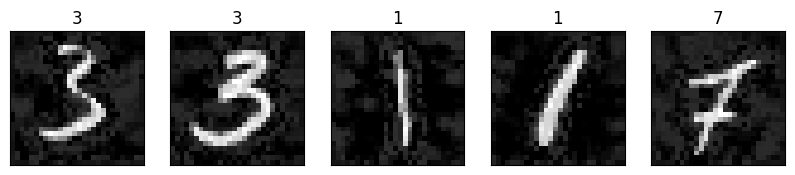

Accuracy for epsilon 0.2: 84.79%


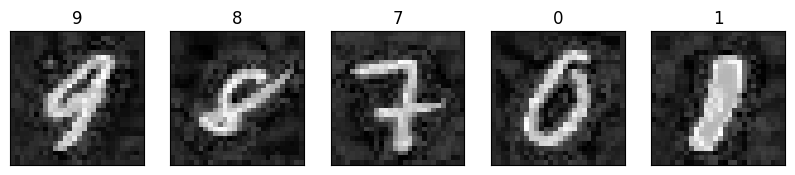

Accuracy for epsilon 0.5: 84.15%


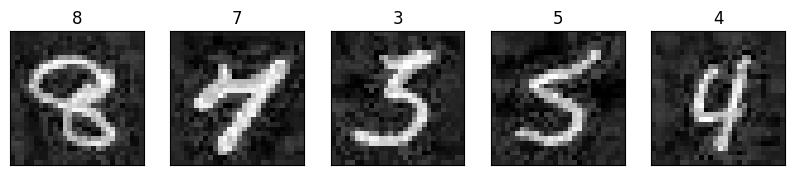

In [ ]:
#pgd model on pgd test
adversarial_report(test_loader, model_pgd, pgd_attack, criterion)